In [1]:
TAKE_EIGEN_VALS = 0
SKIP_EIGEN_VALS = 1
import matplotlib.gridspec as gridspec
import warnings
from sklearn.manifold import LocallyLinearEmbedding

warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import sklearn
import pickle
from IPython.display import display, HTML
import plotly.express as px
sns.set()

import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import matplotlib as mpl
import plotly.express as px

plt.rcParams['figure.figsize'] = [23, 13]
plt.rcParams['figure.dpi'] = 100 # from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['ytick.major.pad'] = 8

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))

In [5]:
def euclidenDistance(data):
    G=np.dot(data,data.T)
    diag=np.diag(G)
    H=diag+diag.T[:,np.newaxis]
    return H-2*G


def centerizedMatrix(data):
    """
    Simple centralizing by the formula given in class.
    @param data:
    @return: centralized data.
    """
    n = data.shape[0]
    H=np.eye(n,n)-(1/n)*np.ones_like(data)
    return -(1/2)*(H@data@H)


def ExtractEigenValuesVectorsSorted(A,d,eig_vals_power=1,skip_first=False):
    if skip_first:
        i=1
    else:
        i=0
    eig_vals,eig_vecs=np.linalg.eig(A)
    eigs_vectors_and_vals=np.vstack([eig_vals,eig_vecs])[:,np.argsort(eig_vals)[::-1]]
    eig_vals=eigs_vectors_and_vals[TAKE_EIGEN_VALS,i:d+i][np.newaxis,:]
    eig_vals_pw_t=np.power(eig_vals,eig_vals_power)
    eig_vecs_tag=eigs_vectors_and_vals[SKIP_EIGEN_VALS:,i:d+i]
    return eig_vals_pw_t,eig_vecs_tag


def heatKernelMatrix(data,sigma,nn=0,binary=False):
    #TODO be sure that nn=0 doesn't fuck things up.
    if nn:
        distance_m=similiary_matrix_knn(data,nn=nn,binary=binary)
    else:
        distance_m=euclidenDistance(data)

    power= -distance_m/sigma
    return np.exp(power)

def stochasicMatrixFromKernel(kernelMatrix):
    D=kernelMatrix.sum(axis=1)
    A=kernelMatrix/(D[:,np.newaxis])
    return A

def DiffusionMap(X, d, sigma, t,nn=0,binary=False):
    '''
    Given a NxD data matrix, return the dimensionally reduced data matrix after
    using the Diffusion Map algorithm. The k parameter allows restricting the
    kernel matrix to only the k nearest neighbor of each data point.

    :param X: NxD data matrix.
    :param d: the dimension.
    :param sigma: the sigma of the gaussian for the kernel matrix transformation.
    :param t: the scale of the diffusion (amount of time steps).
    :return: Nxd reduced data matrix.
    '''
    K=heatKernelMatrix(X,sigma,nn=nn,binary=binary)
    A=stochasicMatrixFromKernel(K)
    eig_val,eig_vecs=ExtractEigenValuesVectorsSorted(A,d,eig_vals_power=t,skip_first=True)

    return eig_val*eig_vecs,A

def run_plot_diff_map(sigma,t,samples , given_sample=False ,X_In=[],ret_fit=False,ax_flag=False,ax=None,no_c=False,binary=False,nn=0):
    X,color=datasets.make_swiss_roll(n_samples=samples)

    if given_sample:
        X,color=X_In

    X_fit,A=DiffusionMap(X=X,d=2,sigma=sigma,t=t,nn=nn,binary=binary)
    X_fit=X_fit.real
    if no_c:
        color=np.ones_like(color)
    if ax_flag:
        ax.scatter(X_fit[:, 0], X_fit[:, 1], c=color, cmap=plt.cm.Spectral)
    else:
        plt.scatter(X_fit[:, 0], X_fit[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.show()

    if ret_fit:
        return X_fit

def d3_scatter(X,color):
    fig = px.scatter_3d(x=X[:, 0], y= X[:, 1], z=X[:, 2],
              color=color,opacity=1,color_continuous_scale='spectral')
    fig.show()

# KNN Diffusion

Instead of using the normal distance  a relative approach tells us that distances doesn't really matter ,
all that we care about is that they're in teh same neighborhood , giving one more power then another point only
because she's close to our original point only mislead us , they all should matter in the same way.

I didn't know which version to implement therefore I did both euclidean k-nn and binary k-nn.


## Implentation block :

In [59]:
X, color = datasets.make_swiss_roll(n_samples=4000)
d3_scatter(X,color)

In [ ]:
def display_np(X):
  display(pd.DataFrame(X))


def similiary_matrix_knn(X,nn=10,binary=False):

  n_samples=X.shape[0]
  euc_dist=euclidenDistance(X)
  sorted_euc=np.argsort(euc_dist,axis=0)
  sorted_euc=sorted_euc[:nn,:]

  #Flatten to fit for array indexing
  #Transpoe beacuse we want [0,..,k] = neighbors of vertex 0 , [k,..,.2k]= nieghbors of vertex 1 and ..
  sorted_euc=sorted_euc.T
  sorted_euc=sorted_euc.flatten()
  #Prepare indexes for  slicing by tiling together the array numbers and then flattening them to fit.
  indxs=np.tile(np.arange(n_samples),(nn,1))
  indxs=indxs.T
  indxs=indxs.flatten()

  #np.inf will ignore every valuse that's not a NN since the kerkenl will
  # be e^-inf
  if binary:
      binary_diss=np.full_like(euc_dist,np.inf)
      binary_diss[indxs,sorted_euc]=1
      binary_diss=binary_diss+binary_diss.T #Make them symmetric.

      return binary_diss

  else:
      euclidean_diss=np.full_like(euc_dist,np.inf)
      euclidean_diss[indxs,sorted_euc]=euc_dist[indxs,sorted_euc]
      return euclidean_diss




## Insights from playing out with KNN Diffusion map :

### Binary :

- The distance doesn't matter and only if they're in the same location , it should favor towards global structure and less
toward local.
- Sigma doesn't matter in the binary case.

So we were able to reconstruct the line graph , and the parabola one :

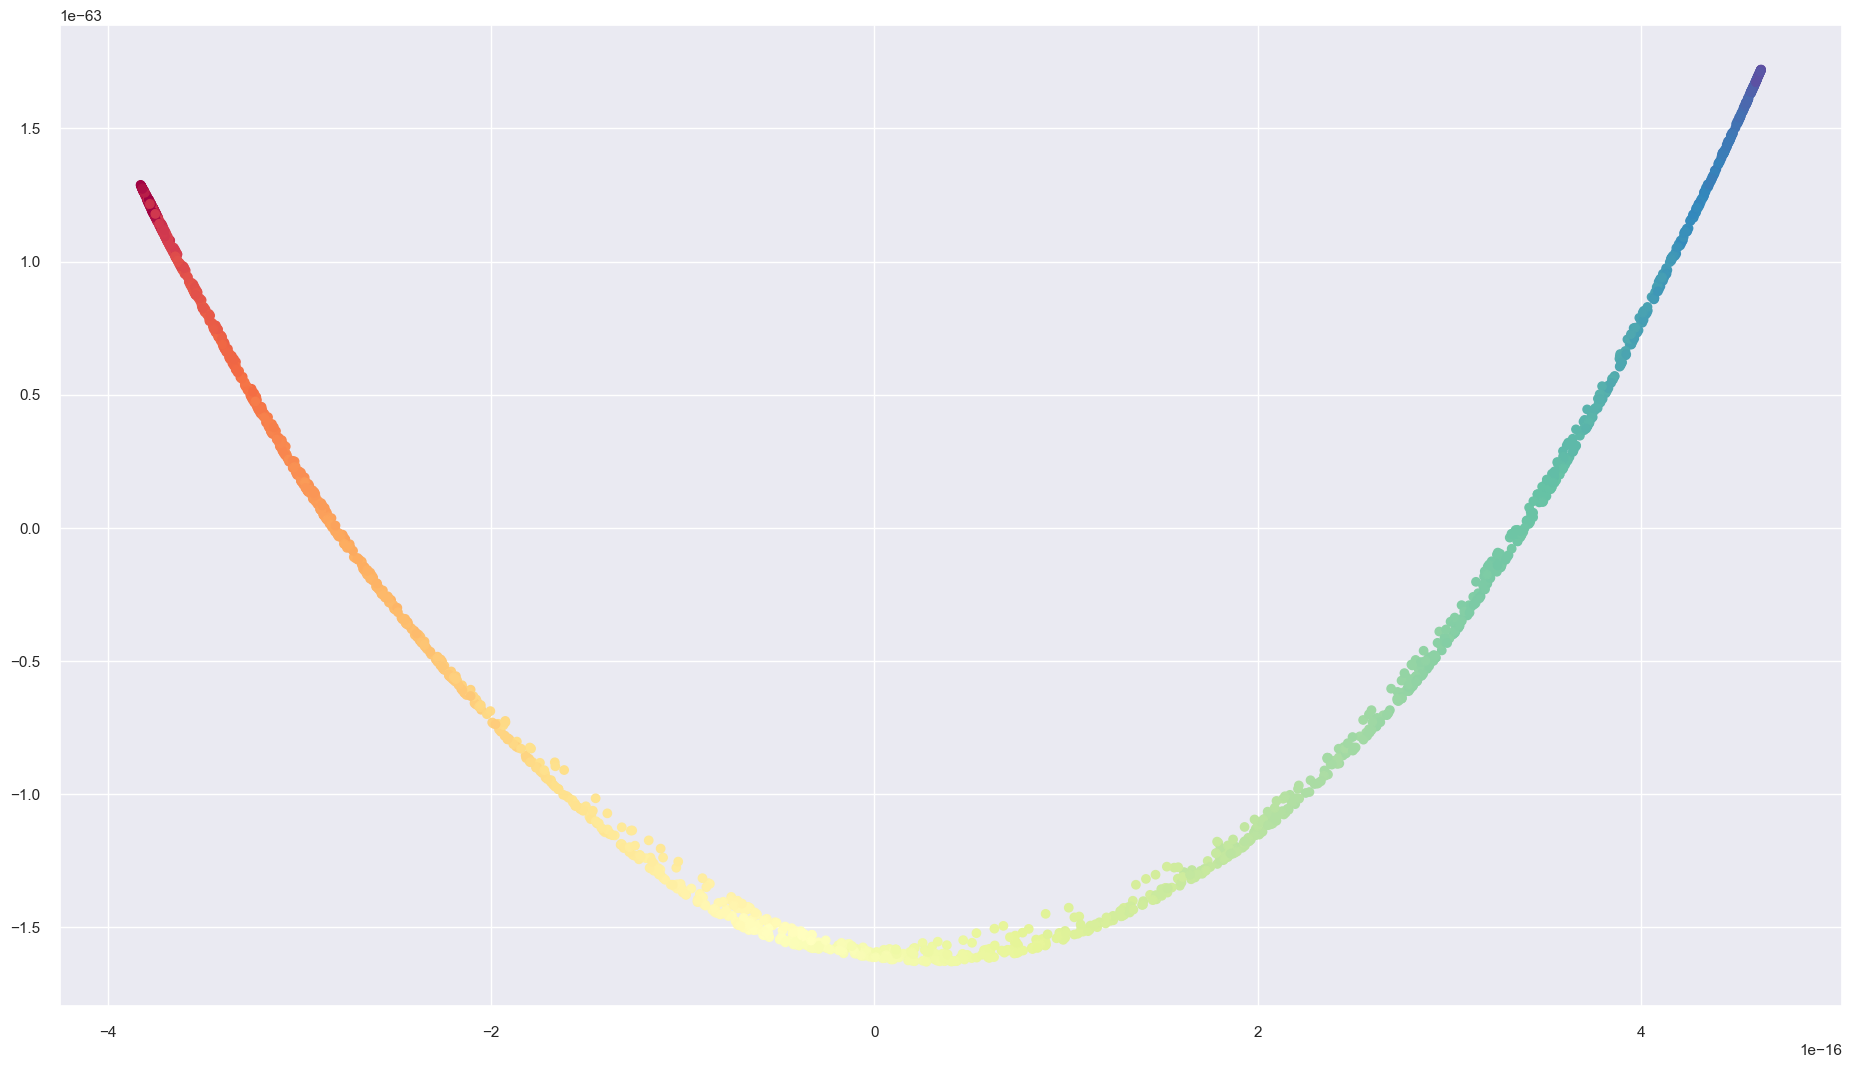

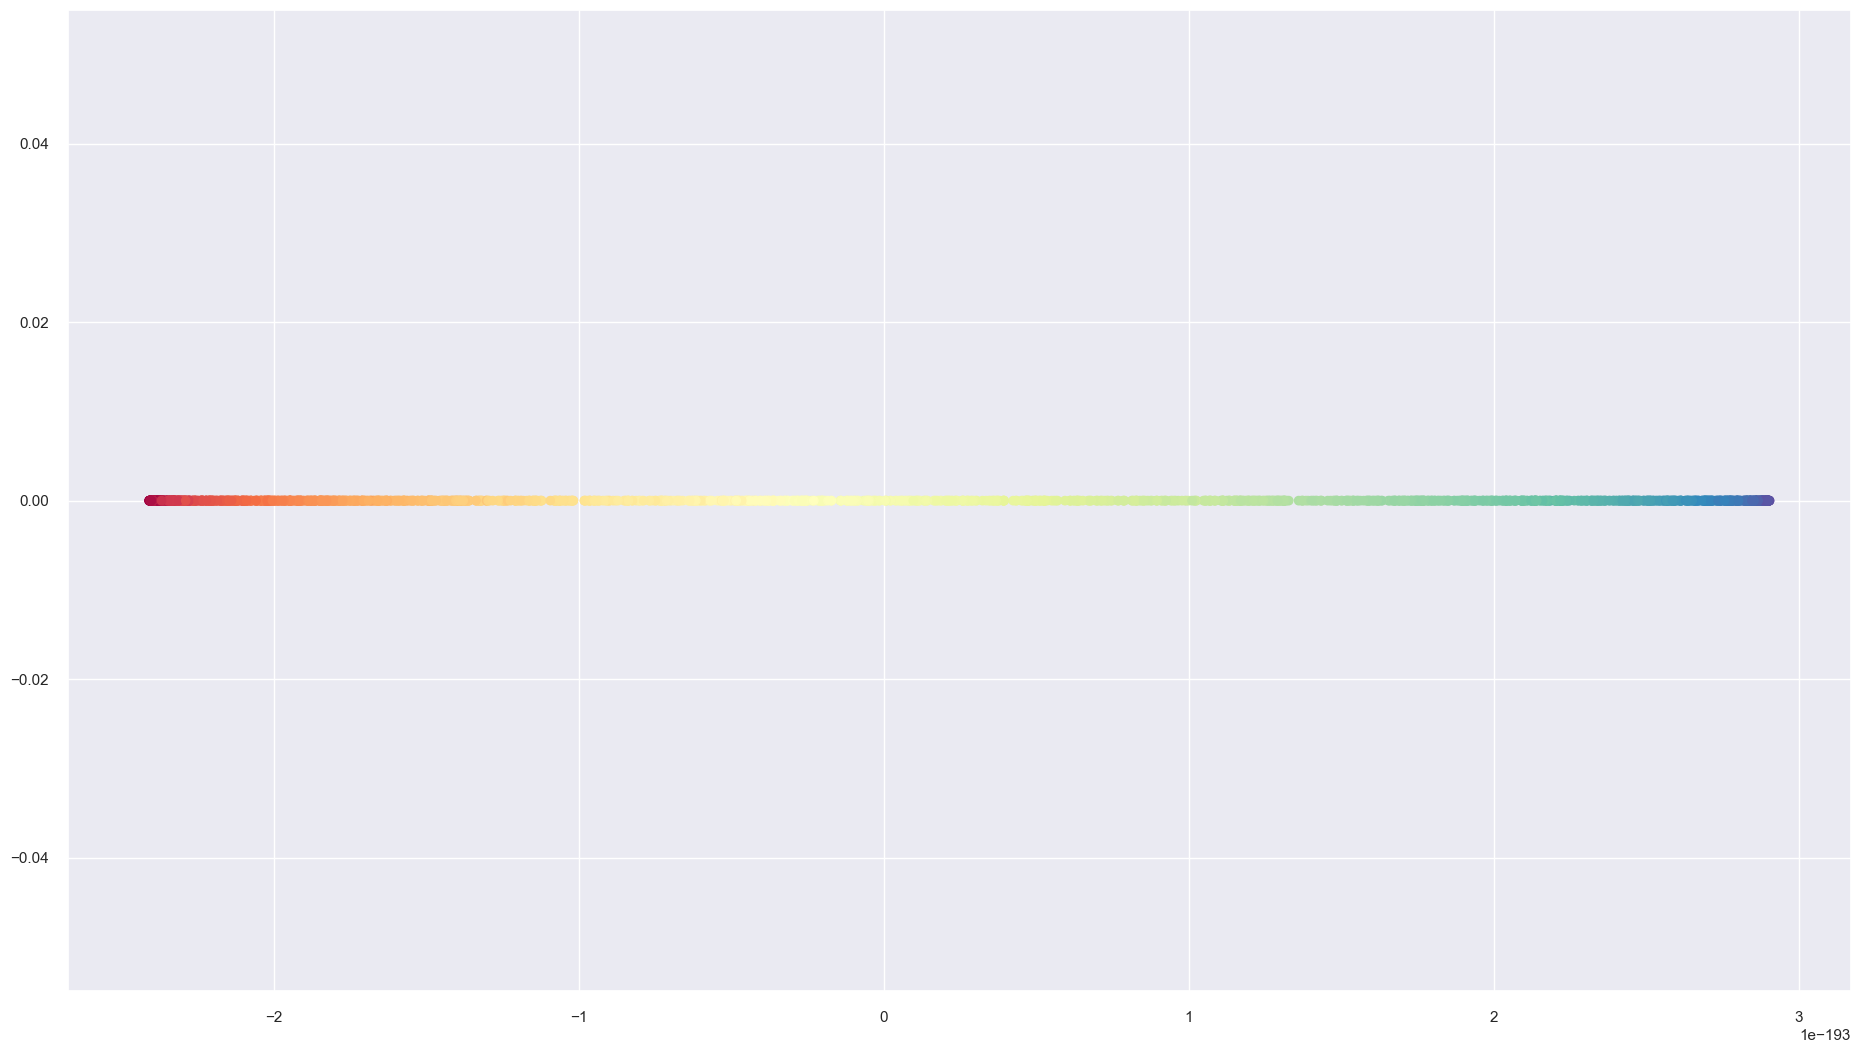

In [378]:
run_plot_diff_map(sigma=100,t=10000,samples=2000,given_sample=True,X_In=(X, color),nn=70,binary=True)
run_plot_diff_map(sigma=100,t=200000,samples=2000,given_sample=True,X_In=(X, color),nn=50,binary=True)

- The parobla is aobut the same , the main differences from last time at least in my version was that it looks much
more like a parabola right now then an approximation of one.
- The line looks about the same with no major difference.

I think i could have spreaded it toward a rectangle if my computer test hypter-parameters over 10k samples
in a reasonble time.


### KNN Diffusion with distance instead binary :
-  Global strcutre should be overall worse than binary , but the local structure should be much better.
- Sigma does have an impact now.

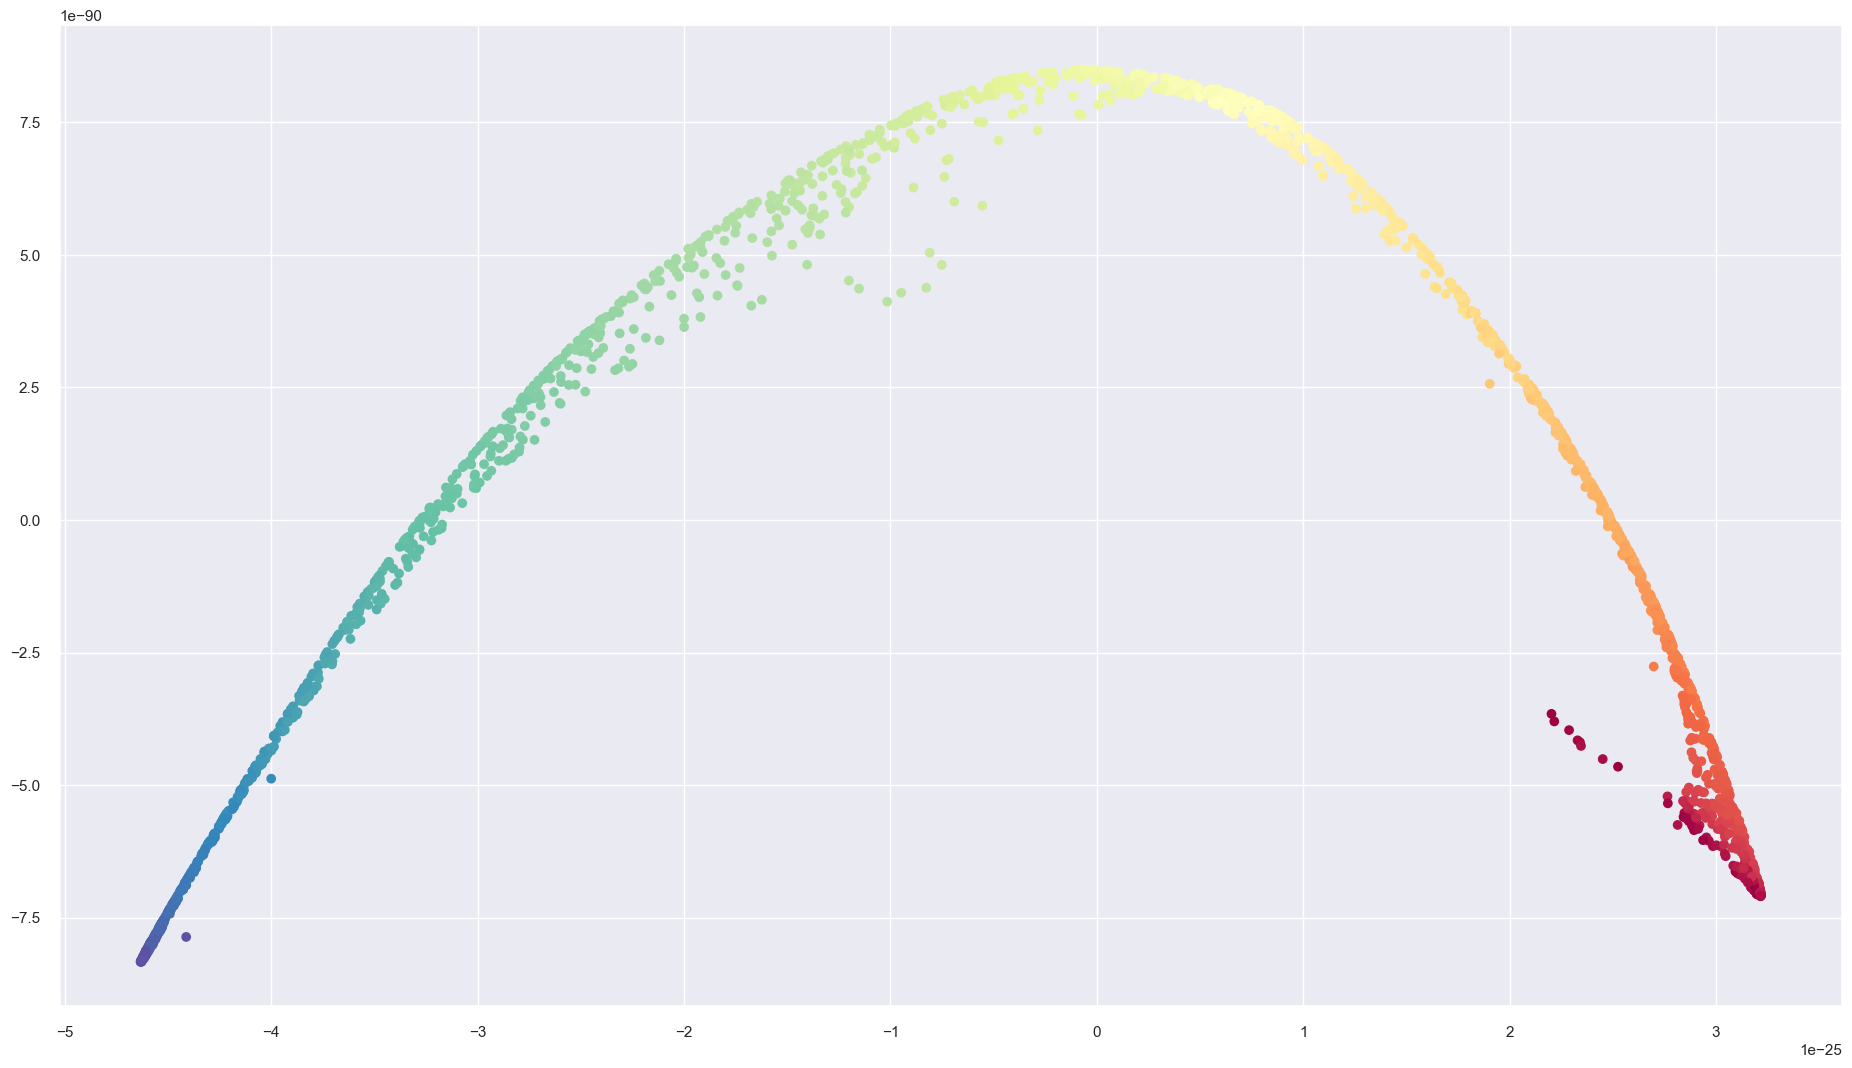

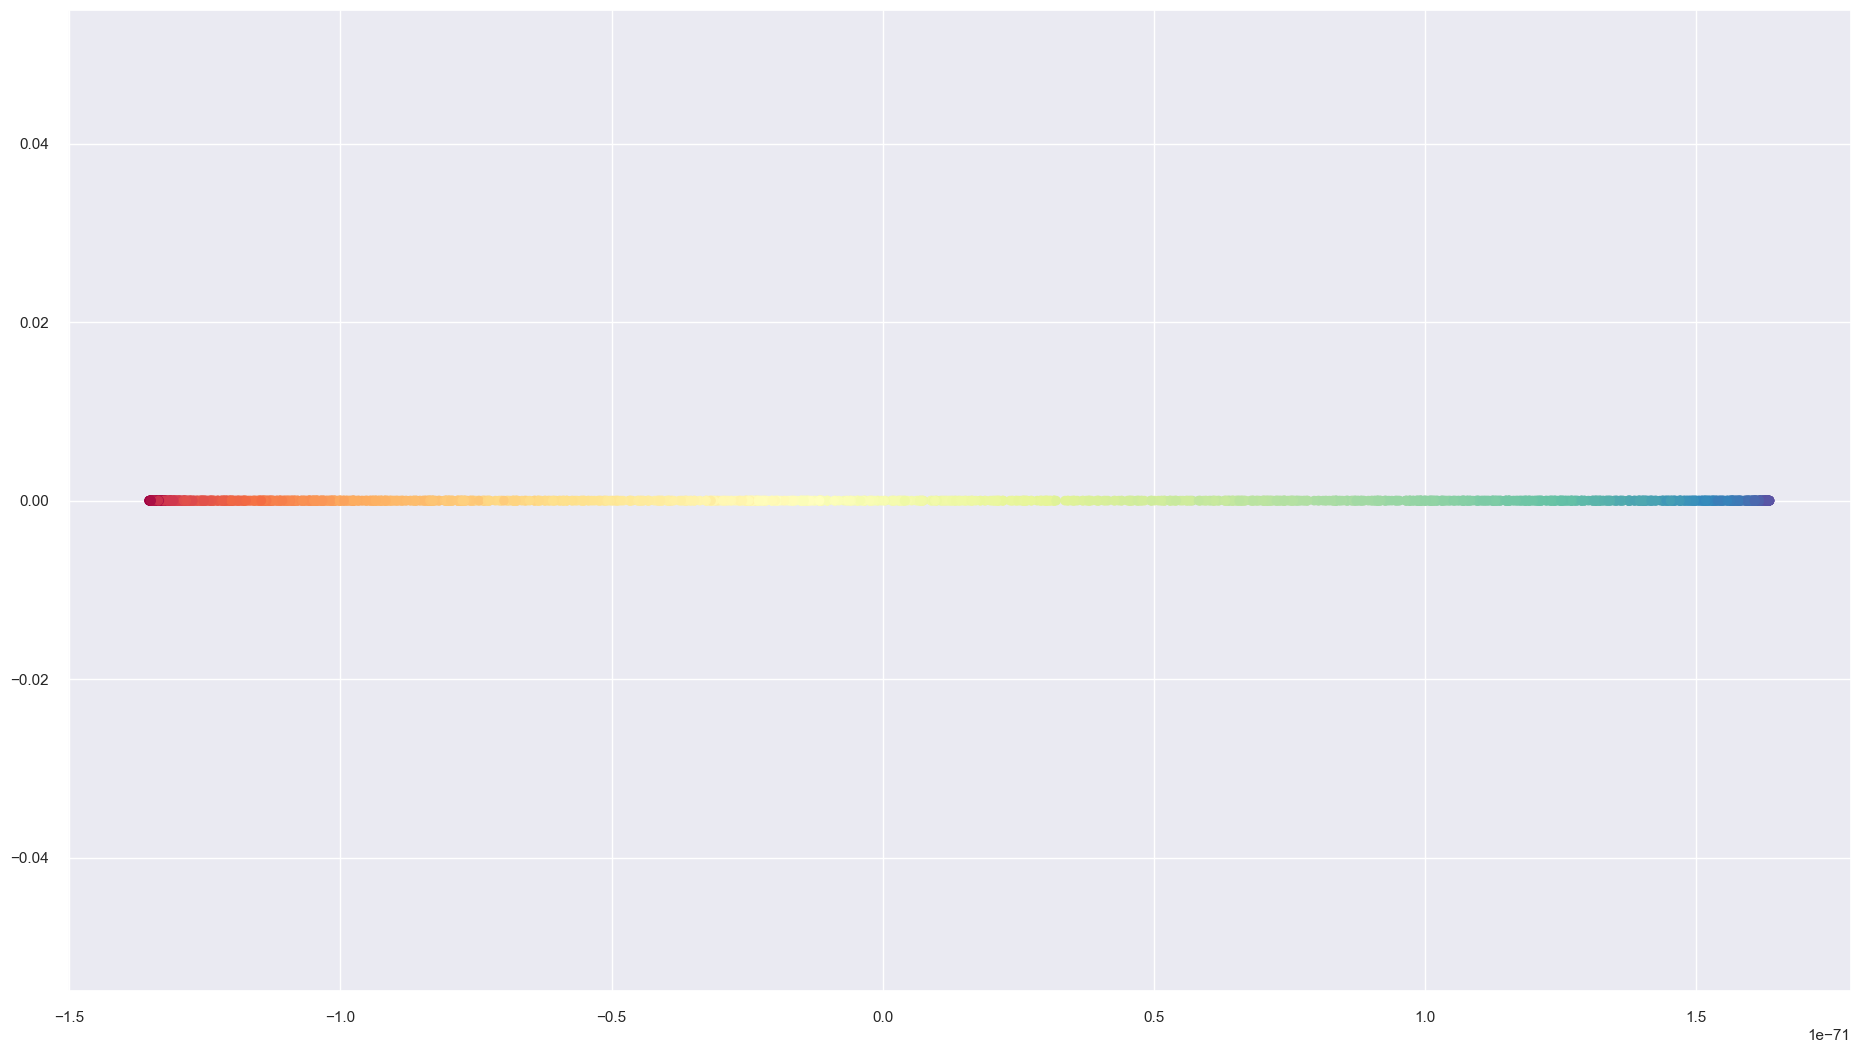

In [412]:
run_plot_diff_map(sigma=100,t=10000,samples=2000,given_sample=True,X_In=(X, color),nn=90,binary=False)
run_plot_diff_map(sigma=100,t=50000,samples=2000,given_sample=True,X_In=(X, color),nn=70,binary=False)


Constrcuting the general global structure and the sparser one is doable as before.

I tried alot of different hyper parameters but couldn't spread it into a rectangle.

### Conclusion :
The NN method is useful to add additional control , if we want the optimal value that promise us that all
the points remain in their own manifold and doesn't invade points that are far away from them ,
it extremely help us to find the best hyper parameter t and sigma wise.

- I guess thinking about that the binary case is a private case of the global one when sigma is very large